<a href="https://colab.research.google.com/github/raaz0000002/pytorch_learning/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets ,transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
# converting MNIST image files into a tensor 4D (# HEIGHT, WIDTH AND COLOR CHANNEL)

transform = transforms.ToTensor()

In [9]:
# Train Data
train_data = datasets .MNIST(root='/content/drive/MyDrive/MNIST data', train=True, download=True, transform=transform)

In [10]:
test_data = datasets .MNIST(root='/content/drive/MyDrive/MNIST data', train=False, download=True, transform=transform)

In [11]:
test_data


Dataset MNIST
    Number of datapoints: 10000
    Root location: /content/drive/MyDrive/MNIST data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [12]:
train_loader = DataLoader(train_data,batch_size=10,shuffle = True)
test_loader = DataLoader(test_data,batch_size=10,shuffle = False)

In [13]:
# defining CNN mode
# defining convolutoin layer and what it is doing.
conv1 = nn.Conv2d(1,6,3,1)  # 1 input size,6 filters(feature maps), 3*3 kernel, 1 stride
conv2= nn.Conv2d(6,16,3,1)  # 6 inputs mathi ko output, esma input


In [14]:
# grap 1 MNIST record/Image
for i,(X_Train,y_train) in enumerate(train_data):
  break

In [15]:
X_Train.shape

torch.Size([1, 28, 28])

In [16]:
x=X_Train.view(1,1,28,28)

In [17]:
# PERFORMING first convolution
x=F.relu(conv1(x))                           # Rectified inear unit for our activation function

In [18]:
x.shape      # 1--> image : 6--> filters : 26*26 -->shrinks because padding  not used.(given 28*28)

torch.Size([1, 6, 26, 26])

In [19]:
# pooling layer
x=F.max_pool2d(x,2,2)   #  2--> kernal size, stride--> 2


In [20]:
x.shape     # size is being shrinked

torch.Size([1, 6, 13, 13])

In [21]:
# second convolution layer
x = F.relu(conv2(x))

In [22]:
x.shape           # stride size reducted .. 2 pixels reduced

torch.Size([1, 16, 11, 11])

In [23]:
# seocnd pooling layer
x=F.max_pool2d(x,2,2)


In [24]:
# 11/2 = 5.5 but rounds down so its 5
x.shape

torch.Size([1, 16, 5, 5])

In [34]:
# Model Class
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,6,3,1)
    self.conv2 = nn.Conv2d(6,16,3,1)
    # Fully Connected Layer
    self.fc1 = nn.Linear(5*5*16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X,2,2) # 2x2 kernal and stride 2
    # Second Pass
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X,2,2) # 2x2 kernal and stride 2

    # Re-View to flatten it out
    X = X.view(-1, 16*5*5) # negative one so that we can vary the batch size

    # Fully Connected Layers
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return F.log_softmax(X, dim=1)

In [35]:
# creating instance of our Mode
torch.manual_seed(41)
model = ConvolutionalNetwork()
model


ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [38]:
# Loss function optimizwer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)  # smaller the learning rate, longer the time to learn



In [39]:
import time
start_time = time.time()

# Create Variables To Tracks Things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For Loop of Epochs
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0


  # Train
  for b,(X_train, y_train) in enumerate(train_loader):
    b+=1 # start our batches at 1
    y_pred = model(X_train) # get predicted values from the training set. Not flattened 2D
    loss = criterion(y_pred, y_train) # how off are we? Compare the predictions to correct answers in y_train

    predicted = torch.max(y_pred.data, 1)[1] # add up the number of correct predictions. Indexed off the first point
    batch_corr = (predicted == y_train).sum() # how many we got correct from this batch. True = 1, False=0, sum those up
    trn_corr += batch_corr # keep track as we go along in training.

    # Update our parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    # Print out some results
    if b%600 == 0:
      print(f'Epoch: {i}  Batch: {b}  Loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corr)


  # Test
  with torch.no_grad(): #No gradient so we don't update our weights and biases with test data
    for b,(X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1] # Adding up correct predictions
      tst_corr += (predicted == y_test).sum() # T=1 F=0 and sum away


  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)



current_time = time.time()
total = current_time - start_time
print(f'Training Took: {total/60} minutes!')


Epoch: 0  Batch: 600  Loss: 0.012505742721259594
Epoch: 0  Batch: 1200  Loss: 0.059554439038038254
Epoch: 0  Batch: 1800  Loss: 0.01286345161497593
Epoch: 0  Batch: 2400  Loss: 0.13558034598827362
Epoch: 0  Batch: 3000  Loss: 0.004820442292839289
Epoch: 0  Batch: 3600  Loss: 0.010546308942139149
Epoch: 0  Batch: 4200  Loss: 0.24395230412483215
Epoch: 0  Batch: 4800  Loss: 0.007479517254978418
Epoch: 0  Batch: 5400  Loss: 0.009367642924189568
Epoch: 0  Batch: 6000  Loss: 0.0018434313824400306
Epoch: 1  Batch: 600  Loss: 0.03221464157104492
Epoch: 1  Batch: 1200  Loss: 0.003333463566377759
Epoch: 1  Batch: 1800  Loss: 0.04126342386007309
Epoch: 1  Batch: 2400  Loss: 0.14685525000095367
Epoch: 1  Batch: 3000  Loss: 0.12026345729827881
Epoch: 1  Batch: 3600  Loss: 0.0001952919119503349
Epoch: 1  Batch: 4200  Loss: 0.00016604487609583884
Epoch: 1  Batch: 4800  Loss: 0.0006250619189813733
Epoch: 1  Batch: 5400  Loss: 0.0019755663815885782
Epoch: 1  Batch: 6000  Loss: 0.0005515654920600355
Ep

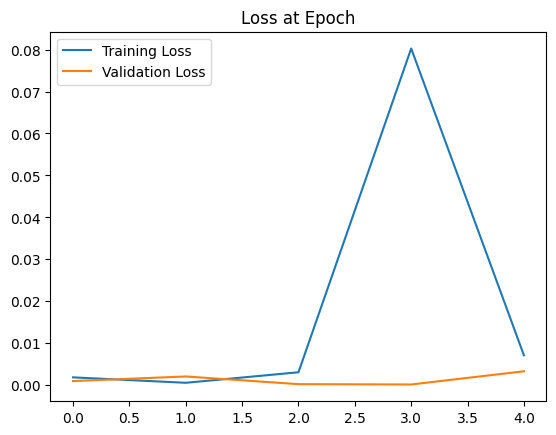

In [40]:

# Graph the loss at epoch
train_losses = [tl.item() for tl in train_losses]
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Validation Loss")
plt.title("Loss at Epoch")
plt.legend()

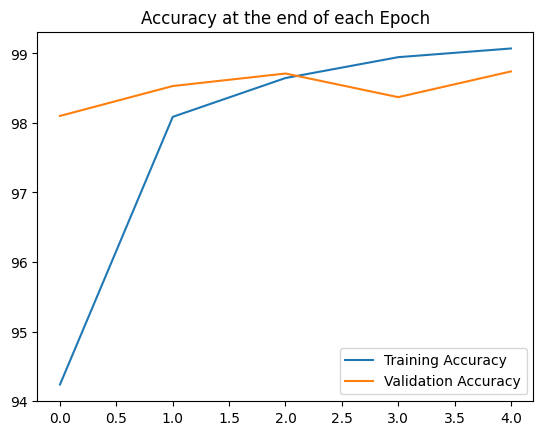

In [41]:
# graph the accuracy at the end of each epoch
plt.plot([t/600 for t in train_correct], label="Training Accuracy")
plt.plot([t/100 for t in test_correct], label="Validation Accuracy")
plt.title("Accuracy at the end of each Epoch")
plt.legend()

In [42]:

test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)

In [43]:

with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val, 1)[1]
    correct += (predicted == y_test).sum()

In [44]:

# Did for correct
correct.item()/len(test_data)*100

98.74000000000001

In [45]:

# Grab an image
test_data[1978] # Tensor with an image in it...at end, it shows the label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [46]:


# Grab just the data
test_data[1978][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [47]:


# Reshape it
test_data[1978][0].reshape(28,28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

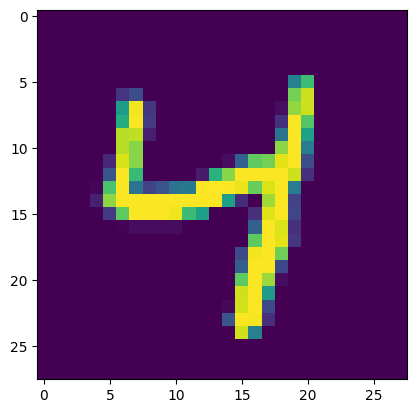

In [48]:

# Show the image
plt.imshow(test_data[1978][0].reshape(28,28))

In [49]:


# Pass the image thru our model
model.eval()
with torch.no_grad():
  new_prediction = model(test_data[1978][0].view(1,1,28,28)) # batch size of 1, 1 color channel, 28x28 image

In [50]:

# Check the new prediction...get probabilities
new_prediction

tensor([[-2.4376e+01, -2.1800e+01, -2.0743e+01, -2.5841e+01, -4.9471e-05,
         -1.7318e+01, -1.7696e+01, -1.8718e+01, -1.6562e+01, -9.9185e+00]])

In [51]:


new_prediction.argmax()


tensor(4)

next program


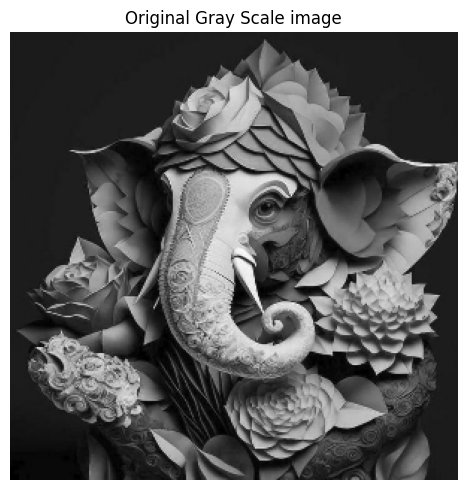

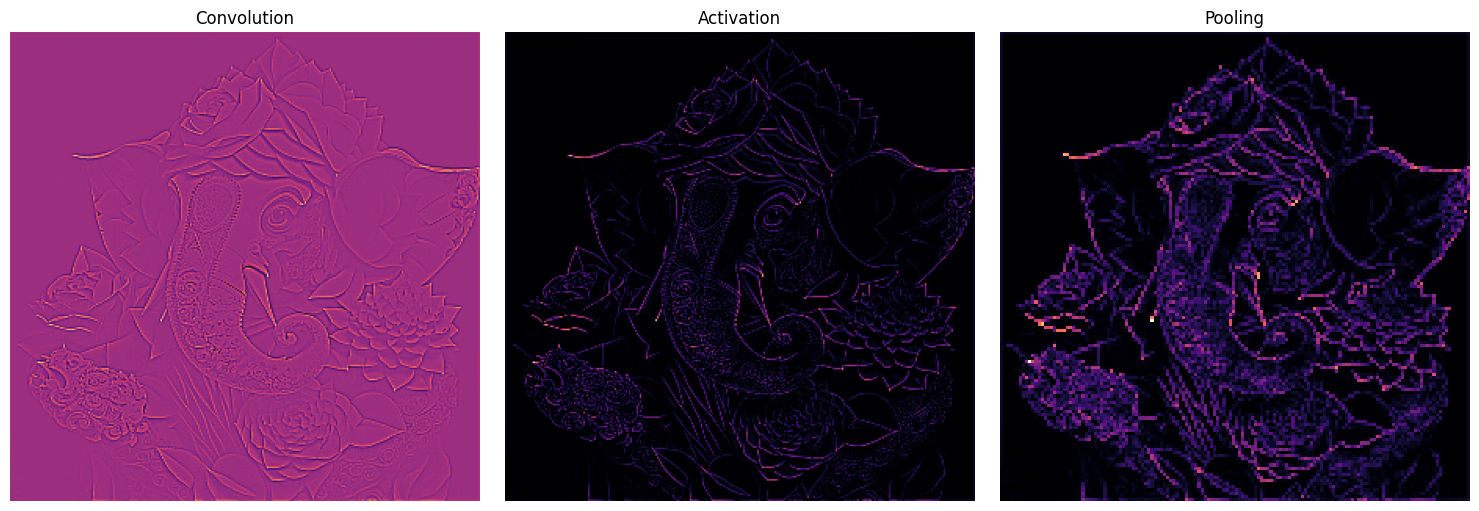

In [ ]:
# import the necessary libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from itertools import product

# set the param
plt.rc('figure', autolayout=True)
plt.rc('image', cmap='magma')

# define the kernel
kernel = tf.constant([[-1, -1, -1],
                    [-1,  8, -1],
                    [-1, -1, -1],
                   ])

# load the image
image = tf.io.read_file('/content/drive/MyDrive/Ganesh.jpg')
image = tf.io.decode_jpeg(image, channels=1)
image = tf.image.resize(image, size=[300, 300])

# plot the image
img = tf.squeeze(image).numpy()
plt.figure(figsize=(5, 5))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('Original Gray Scale image')
plt.show();


# Reformat
image = tf.image.convert_image_dtype(image, dtype=tf.float32)
image = tf.expand_dims(image, axis=0)
kernel = tf.reshape(kernel, [*kernel.shape, 1, 1])
kernel = tf.cast(kernel, dtype=tf.float32)

# convolution layer
conv_fn = tf.nn.conv2d

image_filter = conv_fn(
    input=image,
    filters=kernel,
    strides=1, # or (1, 1)
    padding='SAME',
)

plt.figure(figsize=(15, 5))

# Plot the convolved image
plt.subplot(1, 3, 1)

plt.imshow(
    tf.squeeze(image_filter)
)
plt.axis('off')
plt.title('Convolution')

# activation layer
relu_fn = tf.nn.relu
# Image detection
image_detect = relu_fn(image_filter)

plt.subplot(1, 3, 2)
plt.imshow(
    # Reformat for plotting
    tf.squeeze(image_detect)
)

plt.axis('off')
plt.title('Activation')

# Pooling layer
pool = tf.nn.pool
image_condense = pool(input=image_detect,
                             window_shape=(2, 2),
                             pooling_type='MAX',
                             strides=(2, 2),
                             padding='SAME',
                            )

plt.subplot(1, 3, 3)
plt.imshow(tf.squeeze(image_condense))
plt.axis('off')
plt.title('Pooling')
plt.show()